# Assignment 5 - Track 2
# Stéphanie Larocque et Philip Paquette

## Q1 - Explain how SR can be expressed in the GVF framework (also see corresponding section in S&B if necessary). Expalin this connection using the GVF terminology: cumulant (this is not the notion of "moments" of a prob. distribution), termination condition, etc.

------

From Sutton\&Barto's book, the General Value Function (GVF) equation is:

$$v_{\pi,C, \gamma}(s) = \mathbb{E}\left[\sum\limits_{k=t}^\infty C_{k+1}\prod_{j=t+1}^{k}\gamma(S_i)\ \bigg|\  S_t = s, A_{t:\infty}\sim \pi\right]$$

If we remove the dependency on the state for the discount factor, and keep a constant discount factor, we obtain:

\begin{align*}
	v_{\pi, C, \gamma}(s) 
	&= \mathbb{E}\left[\sum\limits_{k=t}^\infty \gamma^{k-t}C_{k+1}\ \bigg|\  S_t = s, A_{t:\infty}\sim \pi\right]\\
	&= \mathbb{E}\left[C(S_{t+1}) +\gamma\cdot v_{\pi, C, \gamma}(S_{t+1})\ \bigg|\  S_t = s, A_{t:\infty}\sim \pi\right]
\end{align*}
$$$$

The function $C$ is the cumulant function, or pseudo-reward. It can be written in matrix form as
$$ v_{\pi, C, \gamma} = C_\pi + \gamma P_\pi v_{\pi, C, \gamma} $$

and thus
$$ v_{\pi, C, \gamma} = (I + \gamma P_\pi)^{-1}C_\pi $$



We find the SR value function 
$$v_\pi(s)=\phi_\pi(s)^T r_\pi$$
with $\phi_\pi(s)^T = (I + \gamma P_\pi)^{-1}$ and $r_\pi = C_\pi$. The Successor Representation is thus a special case of General Value Function where the cumulant function is the reward function and with a constant discocunted function $\gamma$ as termination function.

## Q2.1 - Learning SR

In [0]:
! pip install numpy
import random
import numpy as np

In [0]:
import random
import numpy as np
np.set_printoptions(precision=1, suppress=True)

# Track 2 - Q1

# Simple Grid World
#
#  _  _  _  G           G = Goal (+1), W = Wall, P = Pit (-1)
#  _  W  _  P
#  _  _  _  _

env_model = {
    'cell_0_0': {'UP': [(1., 0, 'cell_1_0')],
                 'RIGHT': [(1., 0, 'cell_0_1')]},
    'cell_0_1': {"RIGHT": [(1., 0., "cell_0_2")],
                 "LEFT": [(1., 0., "cell_0_0")]},
    'cell_0_2': {"UP": [(1.0, 0., "cell_1_2")],
                 "RIGHT": [(1.0, 0., "cell_0_3")],
                 "LEFT": [(1.0, 0., "cell_0_1")]},
    'cell_0_3': {"UP": [(1.0, 0., "pit")],
                 "LEFT": [(1.0, 0., "cell_0_2")]},
    'cell_1_0': {"UP": [(1.0, 0., "cell_2_0")],
                 "DOWN": [(1.0, 0., "cell_0_0")]},
    'cell_1_2': {"UP": [(1.0, 0., "cell_2_2")],
                 "RIGHT": [(1.0, 0., "pit")],
                 "DOWN": [(1.0, 0., "cell_0_2")]},
    'pit': {"EXIT": [(1.0, -1., "terminal")]},
    "terminal": {"": [(1., 0., "terminal")]},
    'cell_2_0': {"RIGHT": [(1.0, 0., "cell_2_1")],
                 "DOWN": [(1.0, 0., "cell_1_0")]},
    'cell_2_1': {"RIGHT": [(1.0, 0., "cell_2_2")],
                 "LEFT": [(1.0, 0., "cell_2_0")]},
    'cell_2_2': {"RIGHT": [(1.0, 0., "goal")],
                 "LEFT": [(1.0, 0., "cell_2_1")],
                 "DOWN": [(1.0, 0., "cell_1_2")]},
    'goal': {"EXIT": [(1.0, +1., "terminal")]}
}
GAMMA = 0.9
ETA = 0.1

def get_initial_policy(model):
    """ Returns an initial policy that selects the first available action """
    policy = {}
    for state in model:
        policy[state] = [action for action in model[state]]
    return policy

def get_transition_matrix(model, policy):
    """ Computes a transition matrix for a deterministic policy """
    nb_states = len(model)
    T = np.zeros((nb_states, nb_states), dtype=np.float32)
    list_states = sorted([state for state in model])

    for state in model:
        actions = policy[state]
        for action in actions:
            for prob, reward, next_state in model[state][action]:
                s, s_ = list_states.index(state), list_states.index(next_state)
                T[s, s_] = prob / len(actions)
    return T

def get_sr_td(model, policy, nb_trajectories=1000):
    """ Computes the SR matrix using TD(0) """
    nb_states = len(model)
    M = np.eye(nb_states)
    list_states = sorted([state for state in model])
    diag = np.eye(nb_states)

    # Generating trajectories and performing TD(0)
    for _ in range(nb_trajectories):
        state = 'cell_0_0'
        while True:
            actions = policy[state]
            action = random.choice(actions)
            prob, reward, next_state = random.choice(model[state][action])

            s = list_states.index(state)
            s_ = list_states.index(next_state)
            M[s, :] = M[s, :] + ETA * (diag[s] + GAMMA * M[s_, :] - M[s, :])

            if state == 'terminal':
                break
            state = next_state

    # Return M
    return M

def get_sr_calc(model, policy):
    """ Computes the SR matrix using the formula """
    nb_states = len(model)
    I = np.eye(nb_states)
    T = get_transition_matrix(model, policy)
    sr = np.linalg.inv(I - GAMMA * T)
    return sr

initial_pi = get_initial_policy(env_model)
sr_calc = get_sr_calc(env_model, initial_pi)
sr_td0 = get_sr_td(env_model, initial_pi, nb_trajectories=10000)

print('TD 0')
print(sr_td0)
print()
print('Calc')
print(sr_calc)

## ==============================================================
#
# Discussion
#
# From https://papers.nips.cc/paper/5340-design-principles-of-the-hippocampal-cognitive-map.pdf,
# we have established that the TD(0) update rule is as follows:
#
# M(s,j) <-- M(s,j) + eta * [I{s=j} + gamma * M(s',j) - M(s,j)]
#
# We have implemented the TD(0) update rule and reach a matrix M that is very close to the exact solution.
# 
# One of the reason for divergence might be that our policy is stochastic (i.e. it randomly samples an action from
# the list of available actions), therefore it would take a lot of iterations to converge to the exact solution.
#
## ==============================================================


TD 0
[[ 2.2  1.2  0.8  0.2  1.4  0.3  0.7  0.4  0.3  0.1  0.2  2.4]
 [ 1.   1.9  1.4  0.4  0.5  0.5  0.3  0.2  0.2  0.1  0.3  3.3]
 [ 0.4  0.7  1.9  0.5  0.3  0.8  0.2  0.2  0.3  0.1  0.4  4.4]
 [ 0.3  0.4  0.9  1.3  0.2  0.2  0.1  0.1  0.1  0.   0.6  5.7]
 [ 1.3  0.7  0.5  0.2  2.3  0.2  1.3  0.6  0.4  0.1  0.2  2.3]
 [ 0.2  0.2  0.6  0.2  0.1  1.3  0.1  0.2  0.5  0.1  0.5  6. ]
 [ 0.9  0.5  0.3  0.1  1.4  0.3  2.   1.   0.6  0.2  0.1  2.7]
 [ 0.3  0.2  0.2  0.1  0.4  0.4  0.7  1.7  1.1  0.3  0.2  4.4]
 [ 0.2  0.2  0.3  0.1  0.2  0.6  0.3  0.6  1.5  0.4  0.2  5.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   9. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   9. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  10. ]]

Calc
[[ 2.1  1.2  0.7  0.2  1.3  0.3  0.8  0.4  0.3  0.1  0.2  2.4]
 [ 1.2  1.9  1.1  0.3  0.7  0.4  0.5  0.3  0.2  0.1  0.3  3.1]
 [ 0.5  0.7  1.7  0.5  0.3  0.6  0.2  0.2  0.3  0.1  0.4  4.5]
 [ 0.2  0.3  0.8  1.2  0.1  0.3  0.1  0.1  

## Q2.2 - Value Prediction with SR

In [0]:
# Q2

# Computing Value Iteration
def policy_evaluation(model, policy):
    """ Evaluates a policy and returns the value at each state """
    diff = float('inf')
    values = {state: 0. for state in model}

    # Evaluating policy until convergence
    while diff > 1e-5:
        diff = 0

        # For each initial state, selecting action based on policy and re-evaluating
        for state in model:
            state_value = 0
            for action in policy[state]:
                prob_action = 1. / len(policy[state])
                for prob, reward, next_state in model[state][action]:
                    state_value += prob * prob_action * (reward + GAMMA * values[next_state])
            diff += abs(values[state] - state_value)
            values[state] = state_value

    # Returning values
    return values

sorted_states = sorted([state for state in env_model])
reward_vector = [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., -1., 0.]
gvf_values = np.dot(sr_calc, reward_vector)
pol_values = policy_evaluation(env_model, initial_pi)
pol_values = [pol_values[state] for state in sorted_states]

print('-' * 80)
print('GVF')
print(np.array(gvf_values))
print()
print('Policy Evaluation')
print(np.array(pol_values))

## ==============================================================
#
# Discussion
#
# We have implemented a very simple reward function, 
# 1) We get a reward of +1 when exiting from the goal
# 2) We get a reward of -1 when exiting from the pit
# 3) We get a reward of 0. everywhere else.
#
# We have implemented policy evaluation to compute the value of every state if we follow our random policy.
#
# We have also computed the value of every state using the exact SR method calculated in the previous question.
#
# As expected, both methods converge to the exact same value function.
#
# i.e. +1 for goal state, -1 for pit, and values between -1 and +1 for the other states.
#
## ==============================================================

--------------------------------------------------------------------------------
GVF
[-0.1 -0.2 -0.3 -0.6 -0.  -0.3  0.   0.1  0.2  1.  -1.   0. ]

Policy Evaluation
[-0.1 -0.2 -0.3 -0.6 -0.  -0.3  0.   0.1  0.2  1.  -1.   0. ]


## Q2.3 - Tracking with SR

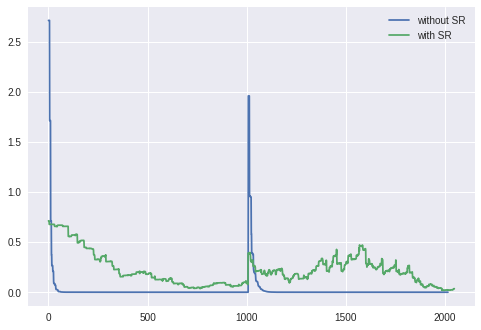

In [0]:
# Q3

def plot_error_policy_eval(model, policy, reward_vector_1, reward_vector_2, sr_calc):
    """ Plots the rewards error """
    list_states = sorted([state for state in env_model])
    values = {state: 0. for state in model}
    errors = []

    nb_iters = 0
    reward_vector = reward_vector_1
    ground_truth = np.dot(sr_calc, reward_vector)
    while nb_iters <= 1000:

        # For each initial state, selecting action based on policy and re-evaluating
        for state in model:
            state_value = 0
            for action in policy[state]:
                prob_action = 1. / len(policy[state])
                for prob, _, next_state in model[state][action]:
                    reward = reward_vector[list_states.index(state)]
                    state_value += prob * prob_action * (reward + GAMMA * values[next_state])

            values[state] = state_value
            nb_iters += 1
            estimate = [values[state] for state in list_states]
            errors += [np.sum(np.square(np.array(estimate) - ground_truth))]

    # New value function
    nb_iters = 0
    reward_vector = reward_vector_2
    ground_truth = np.dot(sr_calc, reward_vector)
    while nb_iters <= 1000:

        # For each initial state, selecting action based on policy and re-evaluating
        for state in model:
            state_value = 0
            for action in policy[state]:
                prob_action = 1. / len(policy[state])
                for prob, _, next_state in model[state][action]:
                    reward = reward_vector[list_states.index(state)]
                    state_value += prob * prob_action * (reward + GAMMA * values[next_state])

            values[state] = state_value
            nb_iters += 1
            estimate = [values[state] for state in list_states]
            errors += [np.sum(np.square(np.array(estimate) - ground_truth))]

    # Returning
    return errors

def plot_error_sr_td0(model, policy, reward_vector_1, reward_vector_2, sr_calc):
    """ Plots the rewards error """
    errors = []

    nb_states = len(model)
    M = np.eye(nb_states)
    list_states = sorted([state for state in model])
    diag = np.eye(nb_states)

    # Generating trajectories and performing TD(0)
    nb_iters = 0
    reward_vector = reward_vector_1
    ground_truth = np.dot(sr_calc, reward_vector)
    while nb_iters <= 1000:
        state = 'cell_0_0'
        while True:
            actions = policy[state]
            action = random.choice(actions)
            prob, reward, next_state = random.choice(model[state][action])

            s = list_states.index(state)
            s_ = list_states.index(next_state)
            M[s, :] = M[s, :] + ETA * (diag[s] + GAMMA * M[s_, :] - M[s, :])
            nb_iters += 1
            estimate = np.dot(M, reward_vector)
            errors += [np.sum(np.square(np.array(estimate) - ground_truth))]

            if state == 'terminal':
                break
            state = next_state

    # Changing reward fn
    nb_iters = 0
    reward_vector = reward_vector_2
    ground_truth = np.dot(sr_calc, reward_vector)
    while nb_iters <= 1000:
        state = 'cell_0_0'
        while True:
            actions = policy[state]
            action = random.choice(actions)
            prob, reward, next_state = random.choice(model[state][action])

            s = list_states.index(state)
            s_ = list_states.index(next_state)
            M[s, :] = M[s, :] + ETA * (diag[s] + GAMMA * M[s_, :] - M[s, :])
            nb_iters += 1
            estimate = np.dot(M, reward_vector)
            errors += [np.sum(np.square(np.array(estimate) - ground_truth))]

            if state == 'terminal':
                break
            state = next_state

    # Return errors
    return errors

reward_vector_1 = [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., -1., 0.]
reward_vector_2 = [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.1, -2., 0.]

errors_no_sr = plot_error_policy_eval(env_model, initial_pi, reward_vector_1, reward_vector_2, sr_calc)
errors_sr = plot_error_sr_td0(env_model, initial_pi, reward_vector_1, reward_vector_2, sr_calc)

import matplotlib.pyplot as plt
plt.plot(errors_no_sr, label = "without SR")
plt.plot(errors_sr, label = "with SR")
plt.legend()

## ==============================================================
#
# Discussion
#
# It's not clear if we have to do this question or not, as the questions changed after being posted.
#
# We computed the value of every state using policy evaluation and SR TD(0)
# As requested, we abrutely changed the reward function after 1,000 steps
#
# From the graph below, we can see that policy evaluation (without SR) has a huge peak after the change of 
# reward function, but SR TD0 stays relatively constant.
#
# This is the expected behaviour.
#
# It can be explained by the fact that SR computes the expected (discounted) occupancy of future states
# and is independent of the reward function.
#
# This is one reason why SR is very useful, especially for multi-task learning.
#
## ==============================================================

## NB : Discussion are at the end of each snippet of code